Author: Jesus Ugarte
University of Central Florida
Algorithms for Machine Learning
median value of houses


In [1]:
import pandas as pd
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import arange
np.seterr(divide = 'ignore') 

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# IMPORTING DATA
train_data = pd.read_csv('/content/drive/MyDrive/Assignment 4 -ML/train.csv').drop(columns=['id'])
sample_data = pd.read_csv('/content/drive/MyDrive/Assignment 4 -ML/sample_submission.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Assignment 4 -ML/test.csv').drop(columns=['id'])
train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.22,37.77,40.0,494.0,114.0,547.0,135.0,2.8015,NEAR BAY,114800.0
1,-122.29,37.76,18.0,2873.0,763.0,1243.0,663.0,5.1702,NEAR BAY,265400.0
2,-118.48,34.23,29.0,3354.0,707.0,1752.0,650.0,4.5484,<1H OCEAN,239900.0
3,-122.19,37.80,48.0,1694.0,259.0,610.0,238.0,4.7440,NEAR BAY,257300.0
4,-121.93,36.63,33.0,1740.0,342.0,638.0,329.0,3.1912,NEAR OCEAN,319800.0
...,...,...,...,...,...,...,...,...,...,...
10315,-117.79,33.70,16.0,1416.0,249.0,636.0,244.0,5.1741,<1H OCEAN,227700.0
10316,-117.41,33.95,37.0,1586.0,283.0,675.0,305.0,2.9583,INLAND,132100.0
10317,-118.65,34.20,23.0,7480.0,1084.0,3037.0,1058.0,6.9223,<1H OCEAN,338400.0
10318,-118.00,34.12,37.0,1340.0,325.0,928.0,333.0,3.9219,INLAND,175000.0


In [3]:
#Taking a look at the sample data 
sample_data

,id,median_house_value
0,0,236845.260799
1,1,276684.540758
2,2,229182.841825
3,3,172216.808070
4,4,271429.197595
...,...,...
10315,10315,213829.851447
10316,10316,200324.752994
10317,10317,267171.484137
10318,10318,146499.166275


In [4]:
# Checking Nan presence
train_data.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
ocean_proximity       False
median_house_value    False
dtype: bool

There are missing values!! I will take care of it in the daata clean up stage

DATA CLEAN UP

In [5]:
#Checking how much data is missing 
train_data['total_bedrooms'].isnull().sum()

110

In [6]:
missing_feature = pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False)).index[0]
missing_feature

'total_bedrooms'

I can see that for total bedrooms there are a total of 110 missing values! 

One of the Important questions when thinking about missing data is How prevalent is the missing data? and Is missing data random or does it have a pattern?

In [7]:
#Apply changes for train data
mean=train_data[missing_feature].mean()
train_data[missing_feature]=train_data[missing_feature].replace(np.nan,mean)
train_data[missing_feature].isnull().sum()


0

In [8]:
#Apply changes for test data
mean=test_data[missing_feature].mean()
test_data[missing_feature]=test_data[missing_feature].replace(np.nan,mean)
test_data[missing_feature].isnull().sum()

0

Not all algorithms fail when there is missing data. There are algorithms that can be made rebust to missing data, such as k-Nearest Neighbors that can ignore a column from a distance measure when a value is missing. Naive Bayes can aslo support missing values when making a prediction.

In [9]:
# Checking Nan presence Again
train_data.isnull().sum().max()


0

Now, There are no more Missing Values in the train data set either in the test set

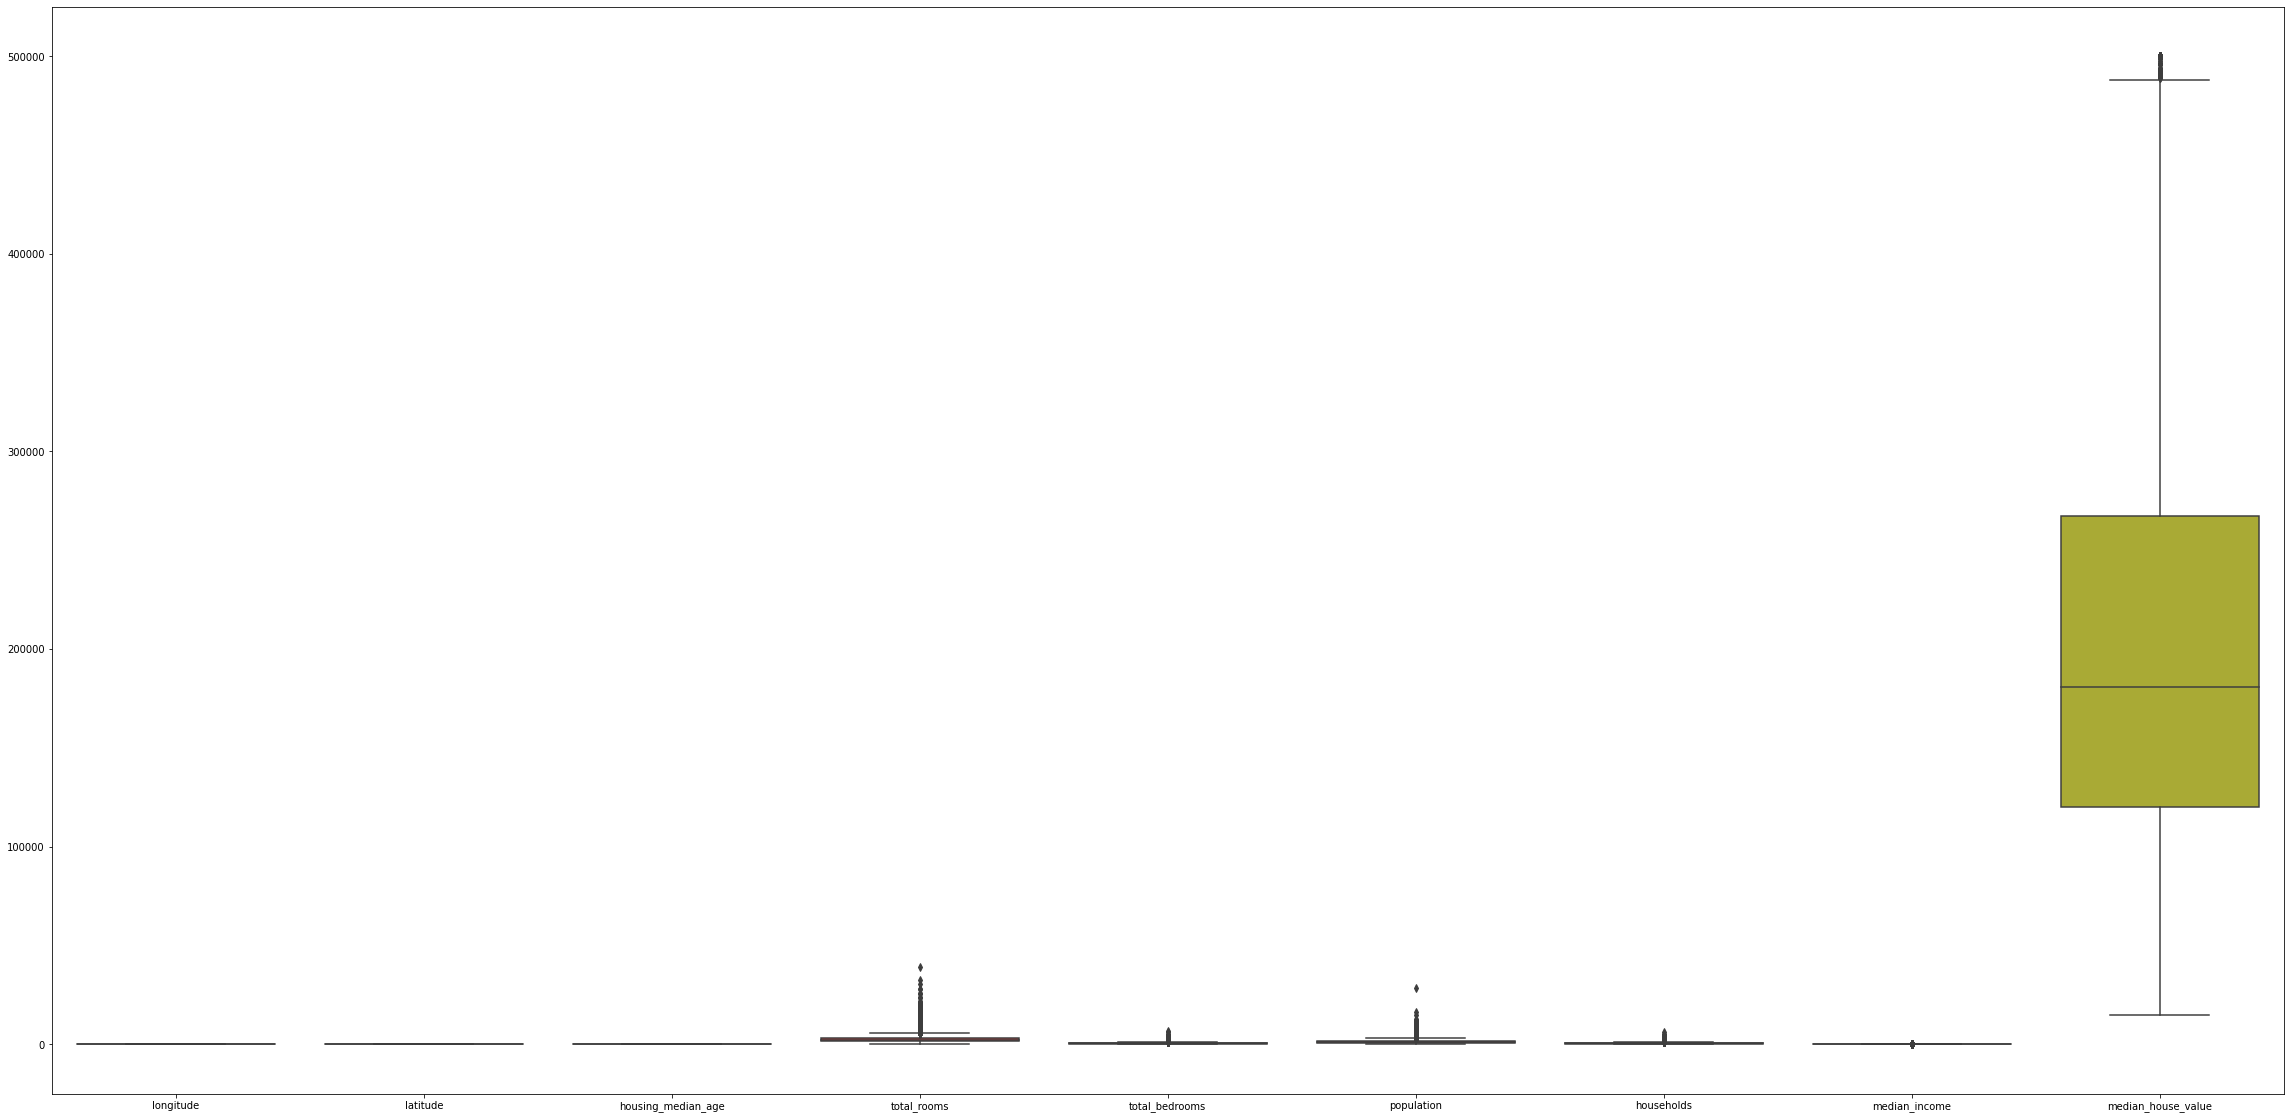

In [10]:
#Checking for outliers
plt.figure(figsize=(40,20))
sns.boxplot(data=train_data)

There are outliers but for now I will NOT do any manipulation on this data!!

In [11]:
q1=train_data.quantile(0.25)
q2=train_data.quantile(0.72)
IQR=q2-q1
#train_data = train_data[~((train_data < (q1 - 1.5 * IQR)) |(train_data > (q2 + 1.5 * IQR))).any(axis=1)]
print(IQR)

longitude                  3.720000
latitude                   3.670000
housing_median_age        18.000000
total_rooms             1518.680000
total_bedrooms           315.000000
population               847.000000
households               295.000000
median_income              1.977016
median_house_value    133100.000000
dtype: float64


UNDERSTANDING THE DATA

In [12]:
#GET DATA INFO
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           10320 non-null  float64
 1   latitude            10320 non-null  float64
 2   housing_median_age  10320 non-null  float64
 3   total_rooms         10320 non-null  float64
 4   total_bedrooms      10320 non-null  float64
 5   population          10320 non-null  float64
 6   households          10320 non-null  float64
 7   median_income       10320 non-null  float64
 8   ocean_proximity     10320 non-null  object 
 9   median_house_value  10320 non-null  float64
dtypes: float64(9), object(1)
memory usage: 806.4+ KB


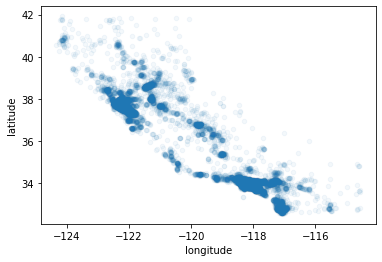

In [13]:
train_data.plot(kind="scatter", x="longitude", y = "latitude", alpha=.05)

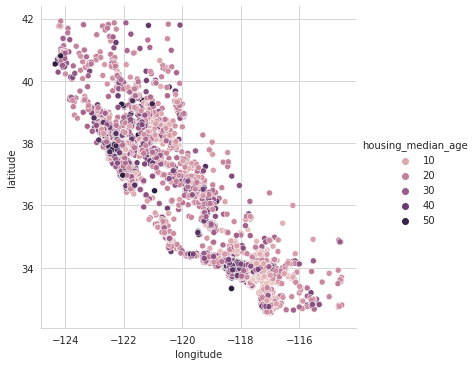

In [14]:
sns.set_style('whitegrid')
sns.relplot(x='longitude', y='latitude', hue='housing_median_age', data=train_data, kind='scatter');

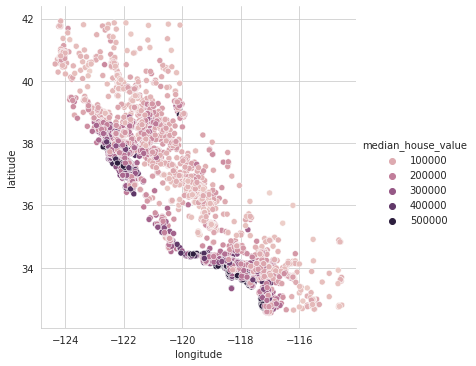

In [15]:
sns.set_style('whitegrid')
sns.relplot(x='longitude', y='latitude', hue='median_house_value', data=train_data, kind='scatter');

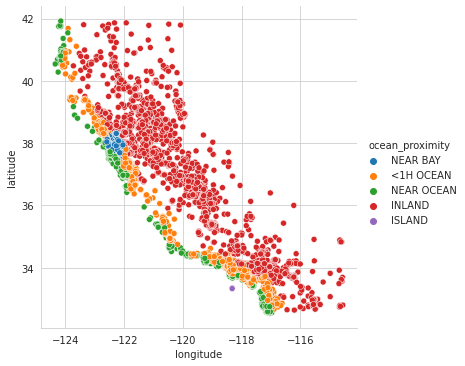

In [16]:
sns.set_style('whitegrid')
sns.relplot(x='longitude', y='latitude', hue='ocean_proximity', data=train_data, kind='scatter');

UNDERSTANDING CATEGORICAL DATA

In [17]:
from collections import Counter
Counter(train_data.ocean_proximity)

Counter({'<1H OCEAN': 4566,
         'INLAND': 3248,
         'ISLAND': 2,
         'NEAR BAY': 1175,
         'NEAR OCEAN': 1329})

In [18]:
train_data.ocean_proximity.value_counts()

<1H OCEAN     4566
INLAND        3248
NEAR OCEAN    1329
NEAR BAY      1175
ISLAND           2
Name: ocean_proximity, dtype: int64

DATA ENCODE

Encode is the process of converting data of one from to another. in this case I will convert the form of ocean proximity object to a more easily machine understandable type. 

In [19]:
#Encode Categorical data
#Ocean Proximity is not an Nominal data
#Ordinal Data can be handled just like numerical columns
dummy = pd.get_dummies(train_data["ocean_proximity"],prefix = "Ocean_" ,).iloc[:,:-1]
train_data=pd.concat([train_data,dummy],axis=1)
train_data=train_data.drop('ocean_proximity', axis =1)
train_data.shape

(10320, 13)

In [20]:
train_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,Ocean__<1H OCEAN,Ocean__INLAND,Ocean__ISLAND,Ocean__NEAR BAY
0,-122.22,37.77,40.0,494.0,114.0,547.0,135.0,2.8015,114800.0,0,0,0,1
1,-122.29,37.76,18.0,2873.0,763.0,1243.0,663.0,5.1702,265400.0,0,0,0,1
2,-118.48,34.23,29.0,3354.0,707.0,1752.0,650.0,4.5484,239900.0,1,0,0,0
3,-122.19,37.80,48.0,1694.0,259.0,610.0,238.0,4.7440,257300.0,0,0,0,1
4,-121.93,36.63,33.0,1740.0,342.0,638.0,329.0,3.1912,319800.0,0,0,0,0


In [21]:
#Encode Categorical data
#Ocean Proximity is not an Nominal data
#Ordinal Data can be handled just like numerical columns

dummy = pd.get_dummies(test_data["ocean_proximity"],prefix = "Ocean_" ,).iloc[:,:-1]
test_data=pd.concat([test_data,dummy],axis=1)
test_data=test_data.drop('ocean_proximity', axis =1)
test_data.shape

(10320, 12)

In [22]:
test_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,Ocean__<1H OCEAN,Ocean__INLAND,Ocean__ISLAND,Ocean__NEAR BAY
0,-122.36,37.94,41.0,2591.0,585.0,1638.0,462.0,1.8220,0,0,0,1
1,-118.37,34.16,17.0,4150.0,1148.0,1808.0,1041.0,3.5051,1,0,0,0
2,-118.29,33.95,40.0,2808.0,695.0,2357.0,627.0,1.9655,1,0,0,0
3,-121.77,38.01,13.0,2983.0,534.0,1417.0,510.0,3.9861,0,1,0,0
4,-118.26,34.08,45.0,2174.0,627.0,1992.0,557.0,2.5428,1,0,0,0


In [23]:
train_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,Ocean__<1H OCEAN,Ocean__INLAND,Ocean__ISLAND,Ocean__NEAR BAY
count,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,-119.593791,35.647997,28.544477,2652.874031,541.297845,1431.618120,502.993605,3.882051,208222.779845,0.442442,0.314729,0.000194,0.113857
std,2.005209,2.132319,12.605356,2215.969393,425.579937,1144.035957,388.016806,1.902330,116152.666840,0.496700,0.464430,0.013920,0.317652
min,-124.350000,32.540000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.810000,33.940000,18.000000,1461.000000,296.000000,786.000000,278.000000,2.583300,120000.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.535000,34.270000,29.000000,2138.000000,441.500000,1165.000000,413.000000,3.550000,180700.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.720000,37.000000,3144.250000,645.000000,1724.000000,607.000000,4.733575,267225.000000,1.000000,1.000000,0.000000,0.000000
max,-114.550000,41.920000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,Ocean__<1H OCEAN,Ocean__INLAND,Ocean__ISLAND,Ocean__NEAR BAY
count,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,-119.545618,35.615726,28.734496,2618.652132,534.447618,1419.335368,496.085756,3.859291,0.442829,0.320058,0.000291,0.108043
std,2.001661,2.139561,12.565620,2146.682432,412.849213,1120.790562,376.543945,1.897334,0.496745,0.466521,0.017048,0.310449
min,-124.300000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000000,0.000000,0.000000,0.000000
25%,-121.770000,33.930000,18.000000,1437.000000,299.000000,788.000000,281.000000,2.543150,0.000000,0.000000,0.000000,0.000000
50%,-118.470000,34.240000,29.000000,2116.000000,435.000000,1167.500000,406.000000,3.517900,0.000000,0.000000,0.000000,0.000000
75%,-118.000000,37.710000,37.000000,3148.250000,642.000000,1726.000000,602.000000,4.750000,1.000000,1.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,37937.000000,5471.000000,35682.000000,5189.000000,15.000100,1.000000,1.000000,1.000000,1.000000


Your solution is restricted to the following models:

Ordinary Least Squares Regression;
Ridge Regression;
Lasso Regression;
ElasticNet Regression


Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

In [25]:
#Normalize the data
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
powerdata = pd.DataFrame(pt.fit_transform(train_data))
powerdata.columns = train_data.columns
powerdata.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,Ocean__<1H OCEAN,Ocean__INLAND,Ocean__ISLAND,Ocean__NEAR BAY
0,0.0,1.044097,0.908856,-1.781192,-1.708870,-1.024191,-1.443342,-0.489910,-0.789578,-0.890806,-0.677699,-0.013923,2.789799
1,0.0,1.040669,-0.809225,0.392340,0.799684,0.059231,0.687291,0.848596,0.681944,-0.890806,-0.677699,-0.013923,2.789799
2,0.0,-0.597724,0.083382,0.626102,0.677737,0.573956,0.655537,0.564697,0.496119,1.122579,-0.677699,-0.013923,-0.358449
3,0.0,1.054350,1.479950,-0.348923,-0.752867,-0.891401,-0.774864,0.657878,0.624671,-0.890806,-0.677699,-0.013923,2.789799
4,0.0,0.615786,0.389839,-0.313334,-0.387773,-0.835791,-0.350544,-0.210985,1.031296,-0.890806,-0.677699,-0.013923,-0.358449


Skewness of data is reduced drastically

In [26]:
#Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaleddata = pd.DataFrame(sc.fit_transform(powerdata))
scaleddata.columns = powerdata.columns
scaleddata.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,Ocean__<1H OCEAN,Ocean__INLAND,Ocean__ISLAND,Ocean__NEAR BAY
0,0.0,1.044097,0.908856,-1.781192,-1.708870,-1.024191,-1.443342,-0.489910,-0.789578,-0.890806,-0.677699,-0.013923,2.789799
1,0.0,1.040669,-0.809225,0.392340,0.799684,0.059231,0.687291,0.848596,0.681944,-0.890806,-0.677699,-0.013923,2.789799
2,0.0,-0.597724,0.083382,0.626102,0.677737,0.573956,0.655537,0.564697,0.496119,1.122579,-0.677699,-0.013923,-0.358449
3,0.0,1.054350,1.479950,-0.348923,-0.752867,-0.891401,-0.774864,0.657878,0.624671,-0.890806,-0.677699,-0.013923,2.789799
4,0.0,0.615786,0.389839,-0.313334,-0.387773,-0.835791,-0.350544,-0.210985,1.031296,-0.890806,-0.677699,-0.013923,-0.358449


RIDGE

Ridge Regression Ridge regression is also a linear model for regression, so the formula it ues to make predictions is the same one for ordinary least squares. we want the magnitue of coefficients to be as small as possible, in other words, all entries of w should be close to zero. 

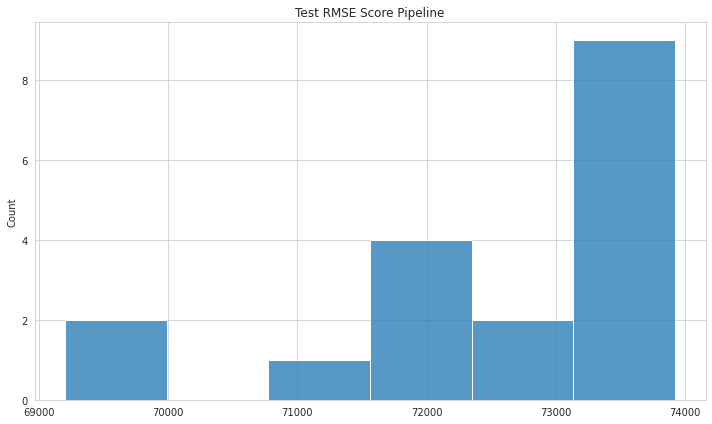

In [27]:
#Combined all steps in pipeline
from sklearn.linear_model import Ridge

#HYPERPARAMETER SEARCH DISTRIBUTION MODEL with GridSearch Cross Validation
test_rmse = []
best_rmse = 0

X=train_data.drop('median_house_value',axis=1)
y=train_data['median_house_value']


for j in arange(0.1, 1.0, 0.05):

  test_set = j

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_set)

  pipe = Pipeline((
  ("pt", PowerTransformer()),
  ("sc",StandardScaler()),
  ("lr", Ridge()),
  ))

  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)

  test_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

  if(best_rmse < mean_squared_error(y_test, y_pred, squared=False)):
    best_rmse = mean_squared_error(y_test, y_pred, squared=False)

f, axs = plt.subplots(figsize=(10, 6))
axs.set_title("Test RMSE Score Pipeline")
sns.histplot(test_rmse, ax = axs)
f.tight_layout()

Lasso

An alternative to Ridge for regularizing linear regression. As with ridge regression, using the Lasso also retricts coefficients to be close to zero, but in slightly different way, called L1 regularization. The consequence of L1 regulazition is that using the Lasso, some coefficients are exactly zero. This means some fearures are entirely ignored by the model. This can be seen as a form of automatic feature selection. Having some coefficients be exactly zero often makes a model easier to interpret and can reveal the most important features of model.

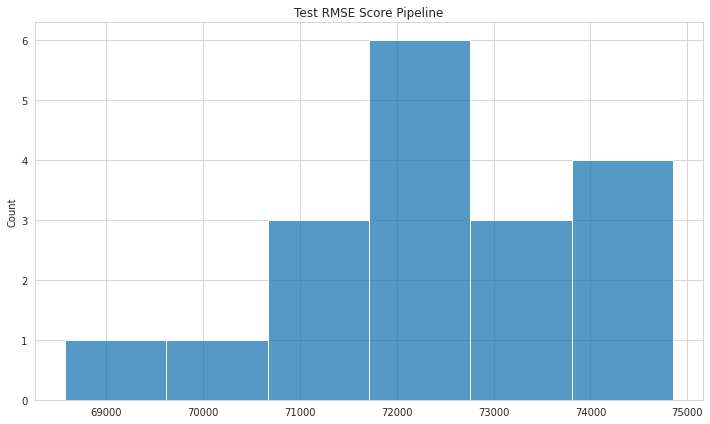

In [28]:
#Combined all steps in pipeline
from sklearn.linear_model import Lasso

#HYPERPARAMETER SEARCH DISTRIBUTION MODEL with GridSearch Cross Validation
test_rmse = []
best_rmse = 0

X=train_data.drop('median_house_value',axis=1)
y=train_data['median_house_value']

for j in arange(0.1, 1.0, 0.05):

  test_set = j

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_set)

  pipe = Pipeline((
  ("pt", PowerTransformer()),
  ("sc",StandardScaler()),
  ("lr", Lasso()),
  ))


  pipe.fit(X_train,y_train)
  y_pred = pipe.predict(X_test)

  test_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

  if(best_rmse < mean_squared_error(y_test, y_pred, squared=False)):
    best_rmse = mean_squared_error(y_test, y_pred, squared=False)

f, axs = plt.subplots( figsize=(10, 6))
axs.set_title("Test RMSE Score Pipeline")
sns.histplot(test_rmse, ax = axs)
f.tight_layout()

ELASTIC NET

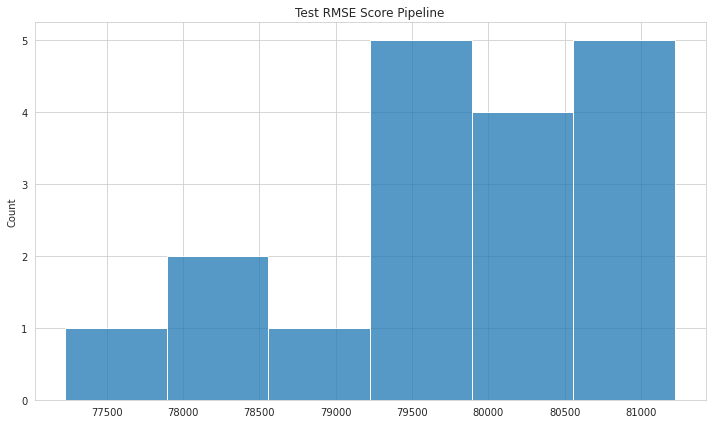

In [29]:
#Combined all steps in pipeline
from sklearn.linear_model import ElasticNet

#HYPERPARAMETER SEARCH DISTRIBUTION MODEL with GridSearch Cross Validation
test_rmse = []
best_rmse = 0

X=train_data.drop('median_house_value',axis=1)
y=train_data['median_house_value']

for j in arange(0.1, 1.0, 0.05):

  test_set = j

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_set)

  pipe = Pipeline((
  ("pt", PowerTransformer()),
  ("sc",StandardScaler()),
  ("lr", ElasticNet()),
  ))


  pipe.fit(X_train,y_train)
  y_pred = pipe.predict(X_test)

  test_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

  if(best_rmse < mean_squared_error(y_test, y_pred, squared=False)):
    best_rmse = mean_squared_error(y_test, y_pred, squared=False)

f, axs = plt.subplots(figsize=(10, 6))
axs.set_title("Test RMSE Score Pipeline")
sns.histplot(test_rmse, ax = axs)
f.tight_layout()

Linear Regression (Ordinary least squares)

Linear regression is the simplest and most classic linear method for regression. Linear regression finds the parameters w and b that minimize the mean squared error between predictions and the true regression targets,y, on the training set.

The mean squared error is the sum of the squared differences between the predictions and the true values.

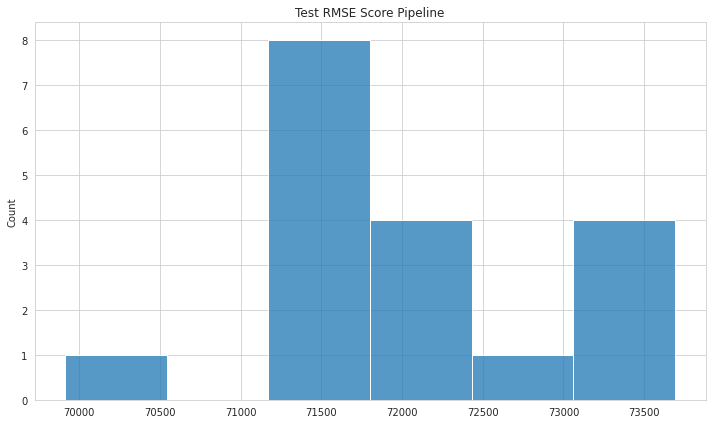

In [36]:
#Combined all steps in pipeline
from sklearn.linear_model import LinearRegression

#HYPERPARAMETER SEARCH DISTRIBUTION MODEL with GridSearch Cross Validation
test_rmse = []
best_rmse = 0

X=train_data.drop('median_house_value',axis=1)
y=train_data['median_house_value']

for j in arange(0.1, 1.0, 0.05):

  test_set = j

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_set)

  model = Pipeline((
  ("pt", PowerTransformer()),
  ("sc",StandardScaler()),
  ("lr", LinearRegression()),
  ))


  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  test_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

  if(best_rmse < mean_squared_error(y_test, y_pred, squared=False)):
    best_rmse = mean_squared_error(y_test, y_pred, squared=False)

f, axs = plt.subplots( figsize=(10, 6))
axs.set_title("Test RMSE Score Pipeline")
sns.histplot(test_rmse, ax = axs)
f.tight_layout()

I will proceed working wiht Linear Regression Model

CREATING CSV WITH GENERATED OUTPUT BASED ON GIVEN TEST DATA SET

In [31]:
#Generating CSV File with Prediction
y_pred = model.predict(test_data)
output = pd.DataFrame({'id': np.arange(0,10320), 'median_house_value': y_pred})
output = output.set_index('id')
output['median_house_value'] = y_pred
output.to_csv("submission.csv")
output

,median_house_value
id,
0,126530.834955
1,260281.741549
2,123317.762619
3,184872.772632
4,176569.630027
...,...
10315,243349.105321
10316,42072.262546
10317,243485.965725


TRYING OTHER CLASSIFIERS OUTSIDE SCOPE OF INITIAL ASSIGNMENT for Score Improvement!!

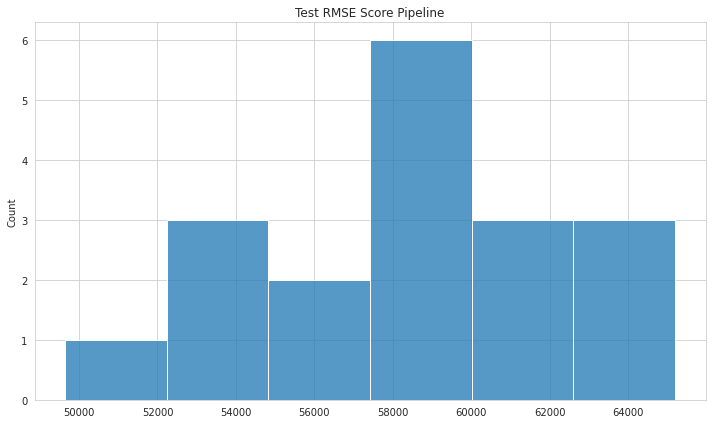

In [32]:
#Combined all steps in pipeline
from sklearn.ensemble import RandomForestRegressor

#HYPERPARAMETER SEARCH DISTRIBUTION MODEL with GridSearch Cross Validation
test_rmse = []
best_rmse = 0

X=train_data.drop('median_house_value',axis=1)
y=train_data['median_house_value']


for j in arange(0.1, 1.0, 0.05):

  test_set = j

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_set)

  model = Pipeline((
  ("pt", PowerTransformer()),
  ("sc",StandardScaler()),
  ("lr", RandomForestRegressor()),
  ))

  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  test_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

  if(best_rmse < mean_squared_error(y_test, y_pred, squared=False)):
    best_rmse = mean_squared_error(y_test, y_pred, squared=False)

f, axs = plt.subplots( figsize=(10, 6))
axs.set_title("Test RMSE Score Pipeline")
sns.histplot(test_rmse, ax = axs)
f.tight_layout()